In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer


# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# sklearn
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# wordCloud
from wordcloud import WordCloud

# pickle
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#loading dataset

file_path = r"C:\Users\PC\Documents\Flatiron\dsc-data-science-env-config\Phase_5_capstone_project\judge_tweet_product_company.csv"
# Our dataset contains special characters or a non-standard encoding.
# We solved this by reading the file using different encoding "ISO-8859-1"
data= pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows to understand the structure
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## 1. Data Understanding

In [3]:
# Checking data information
print("INFO")
print("-" * 4)
data.info()


INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# Find the shape of the DataFrame
data_shape = data.shape

# Print the shape
print("Data Shape:", data_shape)
print("Number of Rows:", data_shape[0])
print("Number of Columns:", data_shape[1])

Data Shape: (9093, 3)
Number of Rows: 9093
Number of Columns: 3


In [5]:
# Columns
print("\n\nCOLUMNS")
print("-" * 6)
print("Columns in the dataset are:")
for idx in data.columns:
    print(f"- {idx}")



COLUMNS
------
Columns in the dataset are:
- tweet_text
- emotion_in_tweet_is_directed_at
- is_there_an_emotion_directed_at_a_brand_or_product


In [6]:
# Unique Values
print("\n\nUNIQUE VALUES")
print("-" * 12)
for col in data.columns:
    print(f"Column *{col}* has {data[col].nunique()} unique values")
    if data[col].nunique() < 12:
        print(f"Top unique values in the *{col}* include:")
        for idx in data[col].value_counts().index:
            print(f"- {idx}")
    print("")



UNIQUE VALUES
------------
Column *tweet_text* has 9065 unique values

Column *emotion_in_tweet_is_directed_at* has 9 unique values
Top unique values in the *emotion_in_tweet_is_directed_at* include:
- iPad
- Apple
- iPad or iPhone App
- Google
- iPhone
- Other Google product or service
- Android App
- Android
- Other Apple product or service

Column *is_there_an_emotion_directed_at_a_brand_or_product* has 4 unique values
Top unique values in the *is_there_an_emotion_directed_at_a_brand_or_product* include:
- No emotion toward brand or product
- Positive emotion
- Negative emotion
- I can't tell



In [7]:
# Missing or Null Values
print("\nMISSING VALUES")
print("-" * 15)
for col in data.columns:
    print(f"Column *{col}* has {data[col].isnull().sum()} missing values.")


MISSING VALUES
---------------
Column *tweet_text* has 1 missing values.
Column *emotion_in_tweet_is_directed_at* has 5802 missing values.
Column *is_there_an_emotion_directed_at_a_brand_or_product* has 0 missing values.


In [8]:
# Duplicate Values
print("\n\nDUPLICATE VALUES")
print("-" * 16)
print(f"The dataset has {data.duplicated().sum()} duplicated records.")



DUPLICATE VALUES
----------------
The dataset has 22 duplicated records.


Comments:

1. All the columns are in the correct data types.

2. The columns will need to be renamed.

3. Features with missing values should be renamed from NaN.

4. Duplicate records should be dropped.

5. All records with the target as "I can't tell" should be dropped.

6. Corrupted records should be removed.

7. Rename values in the is_there_an_emotion_directed_at_a_brand_or_product where the value is 'No emotion toward brand or product' to 'Neutral Emotion'

## 2.Data Cleaning & Feature Engineering

### 2.1 Checking the validity of data


#### 2.1.1 Corrupted data at the *tweet_text* column
There may be an issue of corrupted data in some records. To address this, we create a function that identifies these records and returns their indexes. Corrupted data often includes non-ASCII characters, which may indicate unexpected special symbols, foreign language characters, or encoding issues that do not fit the expected data format. Detecting and removing these records is especially important when working with systems or processes that support only ASCII characters, as non-ASCII characters can cause errors or misinterpretations. By using the identified indexes, we can remove the corrupted records from the working DataFrame, ensuring consistency and compatibility in the dataset.

In [9]:
# A function targeting corrupted records
def is_corrupted(tweet):
    """This func returns the index of any record that is corrupted"""
    corrupted_cols = []
    for key, text in enumerate(tweet):
        if any(ord(char) > 127 for char in str(text)) == True:
            corrupted_cols.append(key)
    return corrupted_cols

In [10]:
# Applying the is_corrupted function to find the indexes of the corrupted records
corrupted_records_idx = is_corrupted(data['tweet_text'])

In [11]:
# Test to check if the function worked as intended
if not data.loc[corrupted_records_idx].empty:
    tweet_text = data.loc[corrupted_records_idx]['tweet_text'].values[0]
    print(tweet_text)
else:
    print("No corrupted records found.")

@mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW


In [12]:
# Drop these records
data.drop(index=corrupted_records_idx, inplace=True)

In [13]:
# Test to ensure there are no corrupted records left
is_corrupted(data['tweet_text'])

[]

#### 2.1.2 Remove records in the *is_there_an_emotion_directed_at_a_brand_or_product* column where the value is "I can't tell."

In [14]:
# Identify records with the specified value
uncertain_reaction_idx = data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"].index

# Remove the identified records
data.drop(index=uncertain_reaction_idx, inplace=True)

# Test & verify removal
data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


#### 2.1.3 Replace Fields in the *is_there_an_emotion_directed_at_a_brand_or_product* column where the value is "No emotion toward brand or product" to "Neutral emotion"

In [15]:
# Identify records with the specified value
neutral_reaction_idx = data[data['is_there_an_emotion_directed_at_a_brand_or_product'] ==\
                              "No emotion toward brand or product"].index

# Remove the identified records
data.loc[neutral_reaction_idx, 'is_there_an_emotion_directed_at_a_brand_or_product'] = "Neutral emotion"

# Test & verify the removal
data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


### 2.2 Completeness of the data

#### 2.2.1 Drop Missing Values in the *tweet_text* column

In [16]:
tweet_missing = data[data['tweet_text'].isnull() == True].index
data.loc[tweet_missing]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,Neutral emotion


In [17]:
# Drop the record
data.drop(index=tweet_missing, inplace=True)

In [18]:
# Test & verify removal
data[data['tweet_text'].isnull() == True]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


#### 2.2.2 Fill Missing Values in the *emotion_in_tweet_is_directed_at* column
This column has over 5000 missing values. This means that a tweet may have been written but the product not identified.  The best cause of action is to take missing values in *emotion_in_tweet_is_directed_at* and attempt to fill them based on the content of the tweet by identifying which product (if any) the tweet is directed at. If a product is not identified, it is assigned the unique value 'None' instead of dropping the rows


In [19]:
# Find the records with missing values in the column
data[data['emotion_in_tweet_is_directed_at'].isnull() == True].shape[0]

5331

In [20]:
# List of unique products/ services
products = list(data.emotion_in_tweet_is_directed_at.unique())
products.remove(np.nan) # Removes any np.nan items

def find_product(tweet):
    """This func takes in a tweet and returns the product talked about in the
    tweet; used to fill in the emotion_in_tweet_is_directed_at column"""
    for product in products:
        if str(product) in tweet or str(product).upper() in tweet \
            or  str(product).lower() in tweet or str(product).title() in tweet:
            return product

# Applying the function to find the index of records with missing values in the 2nd column
missing_products_idx = data[data['emotion_in_tweet_is_directed_at'].isnull() == True].index

In [21]:
# Replace the field where there are missing values in the emotion_in_tweet_is_directed_at column
data.loc[missing_products_idx, 'emotion_in_tweet_is_directed_at'] = data.loc[missing_products_idx, 'tweet_text']\
                                                                        .apply(lambda x: find_product(x))

In [22]:
# In case any field was not captured by our function, we can change it to 'None'
none_index = data[data['emotion_in_tweet_is_directed_at'].isnull()].index
data.loc[none_index, 'emotion_in_tweet_is_directed_at'] = 'None'
# df.loc[none_index]

In [23]:
# Check
data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               2273
Google                             1984
Apple                              1269
iPhone                             1093
None                                720
iPad or iPhone App                  448
Android                             284
Other Google product or service     278
Android App                          77
Other Apple product or service       33
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [24]:
# Number of values in the column are the same as the length of the data
np.sum(data['emotion_in_tweet_is_directed_at'].value_counts().values) == data.shape[0]

True

Observation: 
we were able to assign all tweets to a product and only 720 were not talking about a product explicitly.

### 2.3 Consistency : Dropping the duplicates

In [25]:
# Dropping the duplicates
data.drop_duplicates(inplace=True)

In [26]:
# Check if there is any remaining duplicate values
data.duplicated().sum()

0

### 2.4 Uniformity

#### 2.4.1 Renaming the columns

In [27]:
# Change the column names
data.rename(columns={'tweet_text': "tweet",
                  'emotion_in_tweet_is_directed_at':"product",
                  'is_there_an_emotion_directed_at_a_brand_or_product': "emotion"},
         inplace=True)

In [28]:
# Check
data.columns

Index(['tweet', 'product', 'emotion'], dtype='object')

#### 2.4.2 Reset the Index of the dataframe

In [29]:
# Reset the index
data.reset_index(inplace=True)
# Drop the old index column
data.drop(labels='index', axis=1, inplace=True)
data.head()

,tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### 2.5 Data Cleaning / Feature Engineering result
This is to verify the cleaning and feature engineering process worked


In [30]:
# INFO
print("INFO")
print("----")
print(data.info())

# SHAPE
print("\nSHAPE")
print("-----")
print(f"Records in dataset are {data.shape[0]} with {data.shape[1]} columns.")

# COLUMNS
print("\nCOLUMNS")
print("------")
print("Columns in the dataset are:")
for col in data.columns:
    print(f"- {col}")

 # UNIQUE VALUES
print("\nUNIQUE VALUES")
print("------------")
for col in data.columns:
    unique_values = data[col].nunique()
    print(f"Column *{col}* has {unique_values} unique values")
    if col == 'product' or col == 'emotion': 
        top_values = data[col].value_counts().index[:10].tolist()
        print(f"Top unique values in the *{col}* include:")
        for val in top_values:
            print(f"- {val}")

# MISSING VALUES
print("\nMISSING VALUES")
print("---------------")
for col in data.columns:
    missing_values = data[col].isnull().sum()
    print(f"Column *{col}* has {missing_values} missing values.")

# DUPLICATE VALUES
print("\nDUPLICATE VALUES")
print("----------------")
duplicate_count = data.duplicated().sum()
print(f"The dataset has {duplicate_count} duplicated records.")   

INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439 entries, 0 to 8438
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8439 non-null   object
 1   product  8439 non-null   object
 2   emotion  8439 non-null   object
dtypes: object(3)
memory usage: 197.9+ KB
None

SHAPE
-----
Records in dataset are 8439 with 3 columns.

COLUMNS
------
Columns in the dataset are:
- tweet
- product
- emotion

UNIQUE VALUES
------------
Column *tweet* has 8434 unique values
Column *product* has 10 unique values
Top unique values in the *product* include:
- iPad
- Google
- Apple
- iPhone
- None
- iPad or iPhone App
- Android
- Other Google product or service
- Android App
- Other Apple product or service
Column *emotion* has 3 unique values
Top unique values in the *emotion* include:
- Neutral emotion
- Positive emotion
- Negative emotion

MISSING VALUES
---------------
Column *tweet* has 0 missing values.
Column *product* 

## 3. Data Visualizations

In [31]:
def plot_bar(feature, plot_type='bar'):
    """This function returns a bar or a barh plot"""
    labels = data[feature].value_counts(ascending=(plot_type == 'barh')).index
    values = data[feature].value_counts(ascending=(plot_type == 'barh')).values
    
    if plot_type == 'bar':
        plt.bar(x=labels, height=values)
        plt.ylabel("Count")
        plt.xlabel("Category")
    else:
        plt.barh(y=labels, width=values)
        plt.xlabel("Count")
        plt.ylabel("Categories")
    
    plt.title(f"Distribution of the {feature.title()} feature")
    plt.show()

### 3.1 Distribution of the *emotion* feature

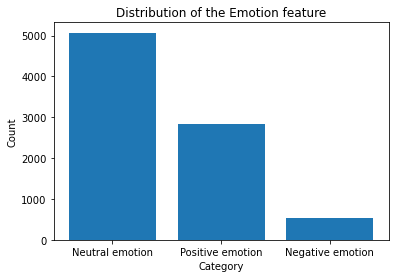

In [32]:
plot_bar('emotion')

The distribution shows a huge class imbalance between categories. The Neutral Emotion category holds over 50% of the data.

### 3.2 Distribution of the *product* feature

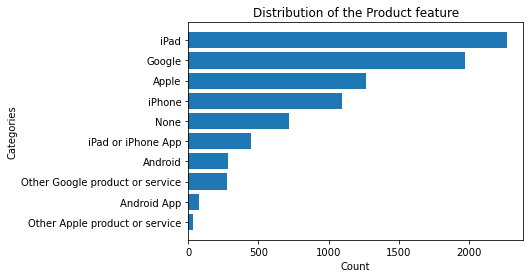

In [33]:
plot_bar('product', plot_type='barh')

The data reveals a high volume of sentiments related to the iPad, which is the most frequently mentioned product in this period, followed closely by sentiments concerning Google and Apple as companies.

Notably, there is also a 'None' category, indicating that a portion of the tweets do not pertain to the Apple or Google products initially targeted in this analysis. This may suggest discussions about other topics or products outside the original scope of the project.

## 4. Text preprocessing

Text processing is a crucial step in preparing raw text data for analysis or machine learning tasks, transforming unstructured text into a more meaningful and manageable format. This process typically includes several important steps:

1. Removing Punctuation: Unnecessary punctuation marks are removed to simplify the text and avoid introducing irrelevant tokens during analysis.

2. Tokenization: The text is split into individual words or phrases (tokens), enabling detailed examination of each component. Tokenization lays the groundwork for all further text processing tasks.

3. Converting to Lowercase: All characters are converted to lowercase to ensure uniformity and prevent duplicate tokens that only differ in case (e.g., "Apple" vs. "apple").

4. Removing Stop Words: Commonly used words (like "and," "is," "the") are filtered out, as they add minimal semantic value. Removing these words helps to focus on the most meaningful terms in the text.

5. Stemming and Lemmatization: Stemming reduces words to their root form by trimming suffixes (e.g., "running" to "run"), while lemmatization transforms words to their base or dictionary form based on context (e.g., "better" to "good"). This step ensures that different variations of a word are treated as a single term, improving consistency in text analysis.

Together, these preprocessing steps help create a cleaner, more structured version of the text, enhancing the accuracy and efficiency of downstream tasks, such as sentiment analysis, topic modeling, and classification.

In [34]:
# Initalize stop words
stop_words = set(stopwords.words('english') + ['sxsw', 'sxswi', 'link', 'rt'])
lemmatizer = WordNetLemmatizer()


Next step is to take the clean, tokenize, lammetize and filter the tweet texts 

In [35]:
def lemmatize_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (keep the text after the #)
    text = re.sub(r'#', '', text)
    # Remove special characters like "&quot;"
    text = re.sub(r'&\w+;', '', text)
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize text
    tokens = re.split('\W+', text.lower())
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Remove extra white spaces
    tokens = [word.strip() for word in tokens if word.strip() != '']
    # Remove numbers
    tokens = [word for word in tokens if not word.isdigit()]
    # Tag parts of speech
    pos_tags = nltk.pos_tag(tokens)
    # Filter tokens to retain only nouns, adjectives, verbs, and adverbs
    important_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}
    tokens = [word for word, tag in pos_tags if tag in important_pos]
    return tokens

Now appliying the lemmatized_tweet function to the 'Tweet' column of the DataFrame 'data', creating a new column called 'lemmatized_tweet' with the processed tokens.

In [36]:
# Apply the clean_text function to the 'tweet' column
data['lemmatized_tweet'] = data['tweet'].apply(lambda x: lemmatize_tweet(x))

def join_text(tokens):
    """
    This function takes a list of tokens (words) and returns them as a single string.
    Each token is separated by a space.

    Parameters:
    tokens (list of str): A list of tokens to be joined.

    Returns:
    str: The tokens joined into a single string separated by spaces.
    """
    return " ".join(tokens)

data['clean_tweet'] = data['lemmatized_tweet'].apply(lambda x: join_text(x))


In [37]:
# Print the cleaned tweets
data.head()

,tweet,product,emotion,lemmatized_tweet,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[iphone, hr, tweeting, riseaustin, dead, need,...",iphone hr tweeting riseaustin dead need upgrad...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[wait, ipad, also, sale]",wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[great, stuff, fri, mayer, google, tim, oreill...",great stuff fri mayer google tim oreilly tech ...


### 4.1 Visualizations for the tokenized tweets

In [147]:
def plot_fdist(sentiment=None, title="Frequency Distribution of Words", df=data):
    """
    Plots the frequency distribution of words in the dataset, optionally filtered by sentiment.
    """

    # Get lemmatized tweets based on sentiment filter
    lemmatized_tweet = df['lemmatized_tweet'] if sentiment is None else df[df['emotion'] == sentiment]['lemmatized_tweet']
    
    # Flatten the list of tokens
    all_tokens = [token for sublist in lemmatized_tweet for token in sublist]

    # Create and plot frequency distribution
    fdist = FreqDist(all_tokens)
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=14)
    fdist.plot(30)


#### 4.1.1 Frequency Distribution of Lemmatized words

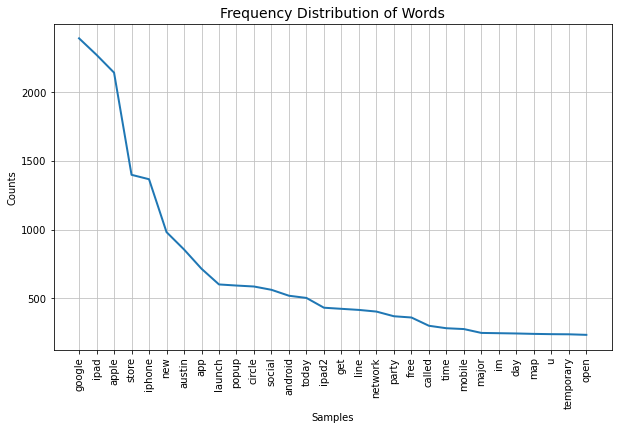

In [148]:
plot_fdist()

With respect to all the data, the words 'google', 'ipad', 'apple', 'store' and iphone appeared more frequently than all other words.

#### 4.1.2 Frequency Distribution of Lemmatized words categorized as Positive Emotion

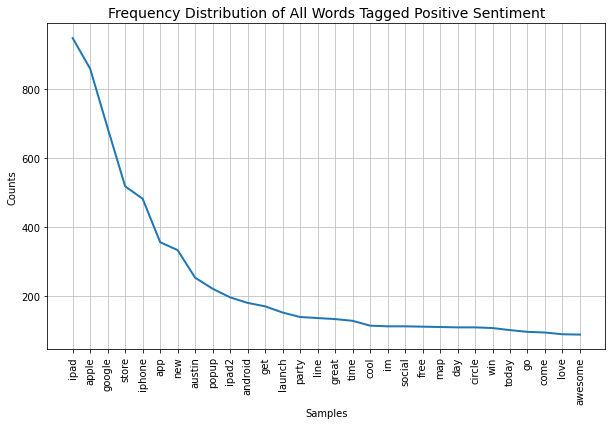

In [149]:
plot_fdist(sentiment="Positive emotion", title="Frequency Distribution of All Words Tagged Positive Sentiment")

With respect to all the data categorised as 'positive', the words 'ipad', 'apple', 'google' and 'store' appeared more frequently than all other words.

Other key positive words introduced in this section include "awesome", "love", "win", "cool", "great", "party"

But were less than the counts recorded in the Neutral Frequency Distributions.

#### 4.1.3 Frequency Distribution of Lemmatized words categorized as Neutral Emotion

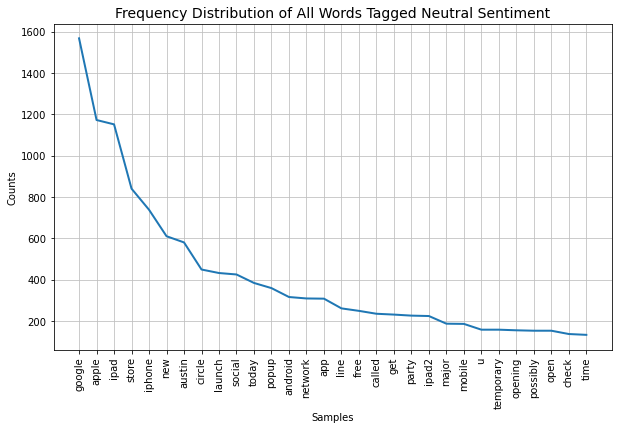

In [150]:
plot_fdist(sentiment="Neutral emotion", title="Frequency Distribution of All Words Tagged Neutral Sentiment")

With respect to all the data categorised as 'neutral', the words 'google', 'apple', 'ipad' and 'store' appeared more frequently than all other words.

This confirms the class imbalance in the dataset.

#### 4.1.4 Frequency Distribution of Lemmatized words categorized as Negative Emotion

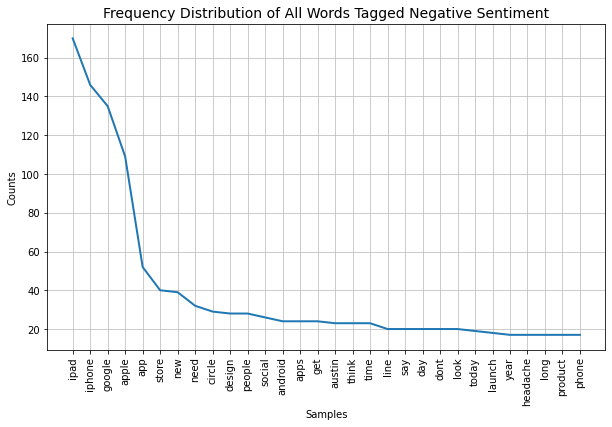

In [151]:
plot_fdist(sentiment="Negative emotion", title="Frequency Distribution of All Words Tagged Negative Sentiment")

With respect to all the data categorised as 'negative', the words 'ipad', 'iphone', 'google' and 'apple' appeared more frequently than all other words. But were less than the counts recorded in the Neutral Frequency Distributions.

## 5. Creating Biagrams
Analyzing bigrams enhances context by examining word pairs together, capturing phrases with meanings that differ from the individual words alone. This approach reveals insights into patterns, expressions, or common associations within the text, offering a deeper understanding of language context.

In [38]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# Alias for BigramAssocMeasures
bigram_measures = BigramAssocMeasures()

In [39]:
def bigram_plots(sentiment=None, title="Bigram of The Data - All Sentiments", df=data, items=20):
    """
    This function returns a horizontal plot of the highest scored bigrams in the dataset
    """
    if sentiment == None:
        lemmatized_tweet = df['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

    elif sentiment != None:
        lemmatized_tweet = df[df['emotion'] == sentiment]['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

    # Create BigramCollocationFinder
    finder = BigramCollocationFinder.from_words(flattened_lemmatized_tweet)

    # Score bigrams by raw frequency
    scored = finder.score_ngrams(bigram_measures.raw_freq)

    # Display the 20 most common bigrams
#     for bigram, score in scored[:20]:
#         print(bigram, score)

    # Order the bigrams
    scores = sorted(scored[:items], key=lambda x: x[1])

    # labels and width
    labels, score = [b[0] + " " + b[1] for b, _ in scores], [score for _, score in scores]

    # Plot
    plt.figure(figsize=(10,6))
    plt.title(title, fontsize=14)
    plt.ylabel("Bigrams")
    plt.xlabel("Scores")
    plt.barh(y=labels, width=score);

### 5.1 Biagrams of all sentiments


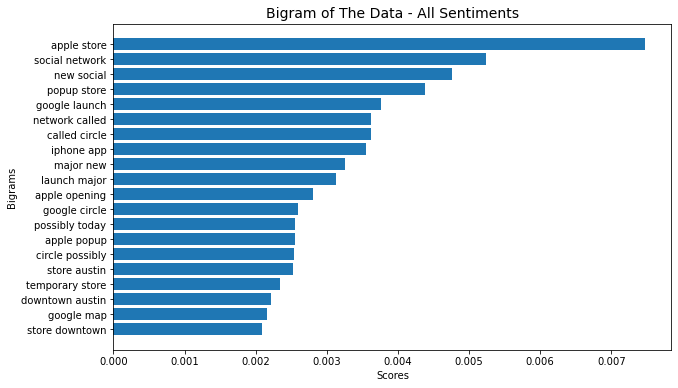

In [36]:
bigram_plots()

"apple store", "social network" and "new social" had the highest scores with respect to all the data available.

### 5.2 Biagrams Positive emotion

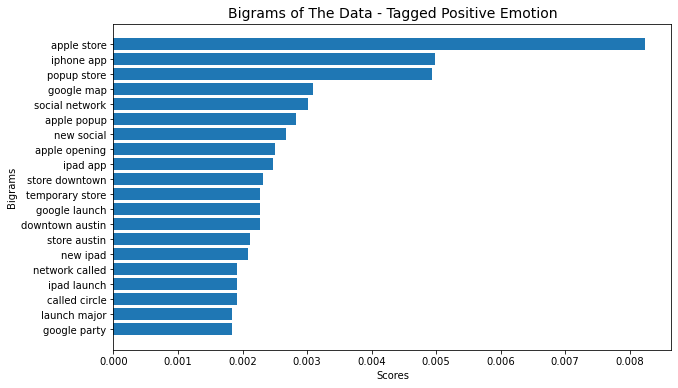

In [37]:
bigram_plots(sentiment='Positive emotion', title='Bigrams of The Data - Tagged Positive Emotion')

"apple store", "iphone app" and "popup store" had the highest scores with respect to all the data categorised as positive.


### 5.3 Biagrams of neutral emotion

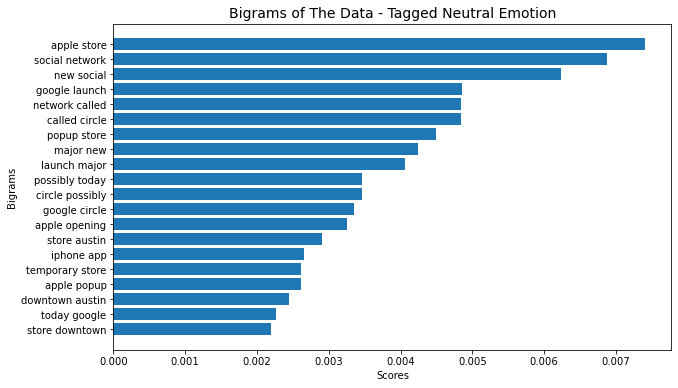

In [156]:
bigram_plots(sentiment='Neutral emotion', title='Bigrams of The Data - Tagged Neutral Emotion')

"apple store", "social network" and "new social" had the highest scores with respect to all the data categorised as neutral.

### 5.4 Biagrams of negative emotion

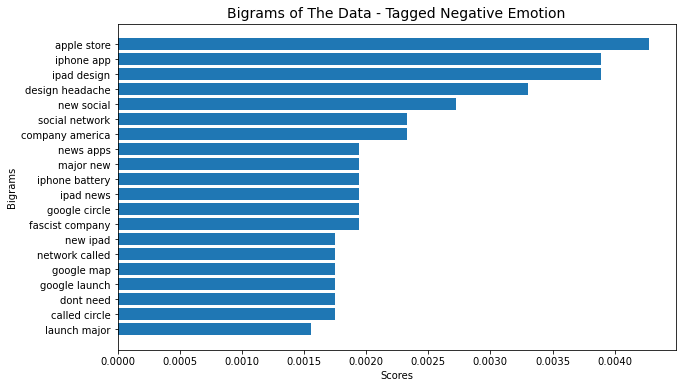

In [157]:
bigram_plots(sentiment='Negative emotion', title='Bigrams of The Data - Tagged Negative Emotion')

"apple store", "iphone app" and "ipad design" had the highest scores with respect to all the data categorised as negative.

## 6. Wordcloud Visual

In [158]:
# installing wordCloud libraries
#!pip install wordcloud

from wordcloud import WordCloud

<Figure size 1440x1440 with 0 Axes>

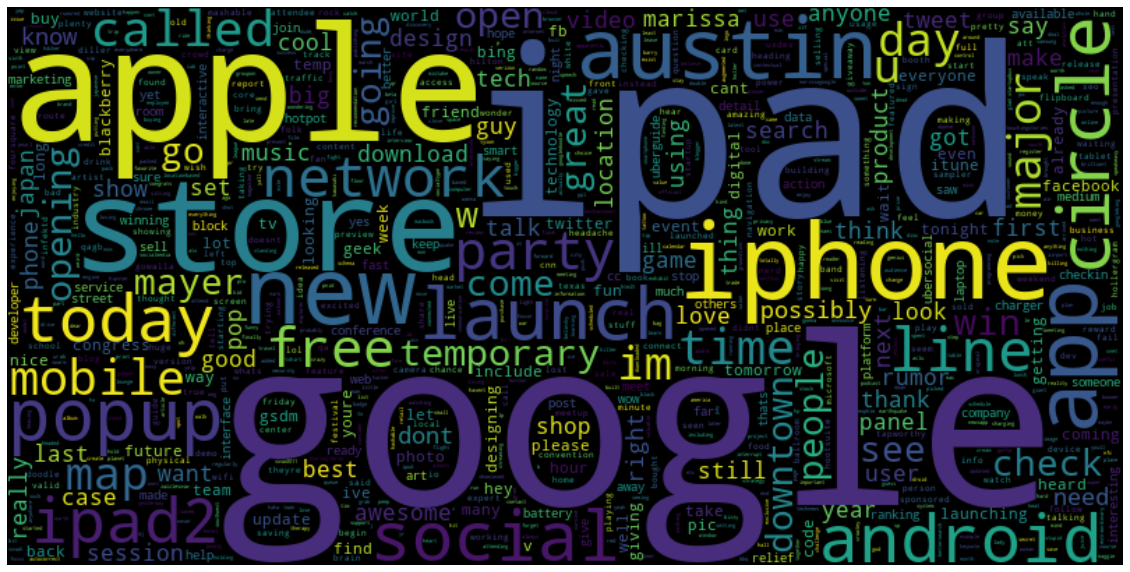

In [159]:
lemmatized_tweet = data['lemmatized_tweet']

# Flatten the list
flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

# Use all processed text directly
data_neg = flattened_lemmatized_tweet[:len(flattened_lemmatized_tweet)]

# Create the word cloud
plt.figure(figsize = (20,20))
WordCloud = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(data_neg))

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(WordCloud, interpolation = 'bilinear')
plt.axis('off')  # Hide axes
plt.show()

## 7. Modelling 

### 7.1 Preprocessing 

Prepare data for modeling by:

1. Label Encoding: Converted emotion labels into numerical values.
2. Vectorization: Used TF-IDF and CountVectorizer to transform text data into numerical vectors.
3. SMOTE: Applied SMOTE to handle class imbalance.
4. Train test split: To split the data

Benefits:

These steps facilitate machine learning algorithms to process the emotion variable, convert text into a numerical format for better analysis, ensure the model is not biased towards the majority class, and provide clear metrics to evaluate performance on unseen data.

#### 7.1.1 Label Encoding

In [40]:
# Classify the data
y = data['emotion']

# Label Enconde the target
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(y)
target[:5]

array([0, 2, 2, 0, 2])

In [41]:
# Confirm labels
label_encoder.classes_

array(['Negative emotion', 'Neutral emotion', 'Positive emotion'],
      dtype=object)

#### 7.1.2 Vectorization : CountVectorizer

In [42]:
# Vectorization - CV
cv = CountVectorizer()

X_vec = cv.fit_transform(data['clean_tweet'])
X_vec = pd.DataFrame.sparse.from_spmatrix(X_vec)
X_vec.columns = sorted(cv.vocabulary_)
X_vec.set_index(y.index, inplace=True)
X_vec = X_vec.iloc[:, 160:]


In [43]:
# Convert sparse to dense before resampling
X_vec = X_vec.sparse.to_dense()

In [44]:
# SMOTE - CV
smote = SMOTE()
X_cv_smote, y_cv_smote = smote.fit_resample(X_vec, target)


# Convert back to DataFrame to retain columns
X_cv_smote = pd.DataFrame(X_cv_smote, columns=X_vec.columns)

In [45]:
# Train Test and split - CV
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv_smote, y_cv_smote, test_size=0.3, random_state=42)

#### 7.1.3 Vectorization : TF-IDF

In [46]:
# Vectorization - TFIDF
tf = TfidfVectorizer()

X_tf = tf.fit_transform(data['clean_tweet'])
X_tf = pd.DataFrame.sparse.from_spmatrix(X_tf)
X_tf.columns = sorted(tf.vocabulary_)
X_tf.set_index(y.index, inplace=True)
X_tf = X_tf.iloc[:, 160:]

In [47]:
# Convert sparse to dense before resampling
X_tf = X_tf.sparse.to_dense()

In [48]:
# SMOTE - TFIDF
X_tf_smote, y_tf_smote = smote.fit_resample(X_tf, target)

# Convert back to DataFrame to retain columns
X_tf_smote = pd.DataFrame(X_tf_smote, columns=X_tf.columns)

In [49]:
# Train Test and Split - TFIDF
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf_smote, y_tf_smote, test_size=0.3, random_state=42)

### 7.2 Models

The machine learning algorithims used in this section are:

1. RandomForest
2. Naive Bayes(MultinomialNB)
3. LogisticRegression
4. DecisionTrees

We will use the split data to predict which model will achieve the highest accuracy and use it for deployment.

In [50]:
def modelling(model, cv=False, tf=False):
    if cv == True:
        # Fit the instantiated model
        model.fit(X_train_cv, y_train_cv)
        # Predict
        y_hat = model.predict(X_test_cv)
        # Results
        print("Count Vectorisation Results\n")
        print("Main Metrics")
        print("-"*12)
        print(f"Accuracy Score {round(accuracy_score(y_test_cv, y_hat), 3)}")
        # Use 'macro' averaging for multiclass classification
        print(f"Recall Score {round(recall_score(y_test_cv, y_hat, average='macro'), 3)}")
        # Classification Report
        print("\nClassification Report")
        print(classification_report(y_test_cv, y_hat))


    elif tf == True:
        # Fit the instantiated model
        model.fit(X_train_tf, y_train_tf)
        # Predict
        y_hat = model.predict(X_test_tf)
        # Results
        print("---------")
        print("TFIDF Vectorisation Results\n")
        print("Main Metrics")
        print("-"*12)
        print(f"Accuracy Score {round(accuracy_score(y_test_tf, y_hat), 3)}")
        # Use 'macro' averaging for multiclass classification
        print(f"Recall Score {round(recall_score(y_test_tf, y_hat, average='macro'), 3)}")
        # Classification Report
        print("\nClassification Report")
        print(classification_report(y_test_tf, y_hat))


In [51]:
def hyper_tuning(model, params, model_name="Random Forest"):
    """This function optimises the base model with the parameters
    passed as params"""
    # Grid Search Base Model
    grid_search_model = GridSearchCV(model, params, cv=5, scoring='accuracy')
    # Count Vectorisation
    # Perform grid search with 5-fold cross-validation for Count Vectorization
    grid_search_rf_cv = grid_search_model.fit(X_train_cv, y_train_cv)

    # Get the best model from grid search for Count Vectorization
    best_rf_model_cv = grid_search_rf_cv.best_estimator_

    # Predict on the test set using the best model for Count Vectorization
    y_pred_cv = best_rf_model_cv.predict(X_test_cv)

    # Calculate and print the accuracy for Count Vectorization
    accuracy_cv = accuracy_score(y_test_cv, y_pred_cv)

    # Calculate and print the recall for Count Vectorization
    recall_cv = recall_score(y_test_cv, y_pred_cv, average ='macro')

    # Results
    print("Count Vectorisation Results\n")
    print(f"Best {model_name.title()} Model (Count Vectorization):\n", best_rf_model_cv)
    print(f"\nTest Accuracy (Count Vectorization): {accuracy_cv:.3f}")
    print(f"\nTest Recall (Count Vectorization): {recall_cv:.3f}")
    print("---------")

    #TFIDF Vectorisation
    grid_search_rf_tf = grid_search_model.fit(X_train_tf, y_train_tf)

    # Get the best model from grid search for TF-IDF Vectorization
    best_rf_model_tf = grid_search_rf_tf.best_estimator_

    # Predict on the test set using the best model for TF-IDF Vectorization
    y_pred_tf = best_rf_model_tf.predict(X_test_tf)

    # Calculate and print the accuracy for TF-IDF Vectorization
    accuracy_tf = accuracy_score(y_test_tf, y_pred_tf)

    # Calculate and print the reacll for TF-IDF Vectorization
    recall_tf= recall_score(y_test_tf, y_pred_tf, average ='macro')

    # Results
    print("\n\nTFIDF Vectorisation Results\n")
    print(f"Best {model_name.title()} Model (TFIDF Vectorization):\n", best_rf_model_tf)
    print(f"\nTest Accuracy (TFIDF Vectorization): {accuracy_tf:.3f}")
    print(f"\nTest Recall (TFIDF Vectorization): {recall_tf:.3f}")

    # models = [best_rf_model_cv, best_rf_model_tf]

    return best_rf_model_cv, best_rf_model_tf

#### 7.2.1 Model 1: Random Forest Classifier


In [52]:
# Instantiate a random forest model
# Set `n_estimators = 1000` , `max_features = 5` and `max_depth = 5`
rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)

In [53]:
modelling(model=rf, cv=True)
modelling(model=rf, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.478
Recall Score 0.481

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.16      0.28      1541
           1       0.73      0.40      0.52      1523
           2       0.38      0.88      0.53      1500

    accuracy                           0.48      4564
   macro avg       0.67      0.48      0.44      4564
weighted avg       0.68      0.48      0.44      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.732
Recall Score 0.732

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1541
           1       0.74      0.52      0.61      1523
           2       0.58      0.84      0.69      1500

    accuracy                           0.73      4564
   macro avg       0.76      0.73      0.73      4564
weighted avg       0.77      0.73      0.73    

Hyperparameter tuning the Random Forest Classifier

In [54]:
# Define the Random Forest classifier
rf = RandomForestClassifier(random_state= 42)

# Define the parameter grid with the necessary hyperparameters
rf_param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30]   # Maximum depth of the tree
}

tuned_rf_cv_model, tuned_rf_tf_model = hyper_tuning(model=rf, params=rf_param_grid, model_name="Random Forest")

Count Vectorisation Results

Best Random Forest Model (Count Vectorization):
 RandomForestClassifier(n_estimators=200, random_state=42)

Test Accuracy (Count Vectorization): 0.706

Test Recall (Count Vectorization): 0.705
---------


TFIDF Vectorisation Results

Best Random Forest Model (TFIDF Vectorization):
 RandomForestClassifier(random_state=42)

Test Accuracy (TFIDF Vectorization): 0.837

Test Recall (TFIDF Vectorization): 0.836


- There is a significant improvement in test accuracy from 0.477 to 0.706 in the model using Count Vectorization.
 
- We can note an indication that TF-IDF provides a superior feature representation for the Random Forest model.

- The accuracy score is at 84% which is an improvement from 73.3%. The models improvement is due to tuning

#### 7.2.2 Model 2: Naive Bayes / (MultinomialNB) model

In [55]:
# Instantiate the MultinomialNB model
mnb = MultinomialNB()

In [56]:
# Classification report of the multinomial using the Count Vectorization
modelling(model=mnb, cv=True)
# Classification report of the multinomial using the TFIDF Vectorization
modelling(model=mnb, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.626
Recall Score 0.626

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1541
           1       0.67      0.58      0.62      1523
           2       0.52      0.59      0.55      1500

    accuracy                           0.63      4564
   macro avg       0.63      0.63      0.63      4564
weighted avg       0.63      0.63      0.63      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.762
Recall Score 0.761

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1541
           1       0.74      0.58      0.65      1523
           2       0.70      0.75      0.72      1500

    accuracy                           0.76      4564
   macro avg       0.76      0.76      0.76      4564
weighted avg       0.76      0.76      0.76    

Hyperparameter tuning the (MultinomialNB) model

In [57]:
# params
mnb_param_grid = {
    'alpha': [0.01, 0.1]
}

# GridSearchCV for tuning
tuned_mnb_cv_model, tuned_mnb_tf_model = hyper_tuning(model=mnb, params=mnb_param_grid, model_name="MNB")

Count Vectorisation Results

Best Mnb Model (Count Vectorization):
 MultinomialNB(alpha=0.01)

Test Accuracy (Count Vectorization): 0.660

Test Recall (Count Vectorization): 0.659
---------


TFIDF Vectorisation Results

Best Mnb Model (TFIDF Vectorization):
 MultinomialNB(alpha=0.01)

Test Accuracy (TFIDF Vectorization): 0.795

Test Recall (TFIDF Vectorization): 0.795


- The accuracy score is at 79.8% which is an improvement from 76.7%. 

- Note the improvement from 0.66 to 0.798 for the model using TF-IDF Vectorization

#### 7.2.3 Model 3: Logistic Regression


In [58]:
# Instantiate the Logistic Regression Model
lr = LogisticRegression(max_iter=200)

In [59]:
modelling(model=lr, cv=True)
modelling(model=lr, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.706
Recall Score 0.704

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.91      0.81      1541
           1       0.71      0.65      0.68      1523
           2       0.65      0.55      0.60      1500

    accuracy                           0.71      4564
   macro avg       0.70      0.70      0.70      4564
weighted avg       0.70      0.71      0.70      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.803
Recall Score 0.802

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1541
           1       0.72      0.74      0.73      1523
           2       0.77      0.70      0.73      1500

    accuracy                           0.80      4564
   macro avg       0.80      0.80      0.80      4564
weighted avg       0.80      0.80      0.80    

In [60]:
# A secondary model manually tuned
lr_tune = LogisticRegression(max_iter=3000, C=100, solver='liblinear')
modelling(lr_tune, cv=True)
modelling(lr_tune, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.71
Recall Score 0.709

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1541
           1       0.71      0.66      0.68      1523
           2       0.65      0.56      0.60      1500

    accuracy                           0.71      4564
   macro avg       0.70      0.71      0.70      4564
weighted avg       0.70      0.71      0.70      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.831
Recall Score 0.83

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1541
           1       0.79      0.71      0.75      1523
           2       0.76      0.79      0.77      1500

    accuracy                           0.83      4564
   macro avg       0.83      0.83      0.83      4564
weighted avg       0.83      0.83      0.83      

Hyperparameter Tuning Logistic Regression Model

In [61]:
# Parameter Tuning
c_space = np.linspace(30, 32, 3)
max_iters = [100, 150, 200]
solvers = ["lbfgs", "liblinear"]
lr_param_grid = { 'C': c_space, 'max_iter':max_iters }
tuned_lr_cv_model, tuned_lr_tf_model = hyper_tuning(model=lr, params=lr_param_grid, model_name="Logistic Regression")

Count Vectorisation Results

Best Logistic Regression Model (Count Vectorization):
 LogisticRegression(C=31.0)

Test Accuracy (Count Vectorization): 0.707

Test Recall (Count Vectorization): 0.705
---------


TFIDF Vectorisation Results

Best Logistic Regression Model (TFIDF Vectorization):
 LogisticRegression(C=31.0, max_iter=150)

Test Accuracy (TFIDF Vectorization): 0.831

Test Recall (TFIDF Vectorization): 0.830


- Count Vectorization based model improved in test accuracy from 0.705 to 0.706

- TF-IDF Vectorization-based model improved from 0.805 to 0.828 after hyperparameter tuning.

- Further indication that the TF-IDF vectorisation is better

#### 7.2.4 Model 4: Decision Trees

In [62]:
#  Instantiate the Decision tree model
dt = DecisionTreeClassifier(max_features=5)

In [63]:
modelling(dt, cv=True)
modelling(dt, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.683
Recall Score 0.682

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.93      0.81      1541
           1       0.68      0.59      0.63      1523
           2       0.63      0.52      0.57      1500

    accuracy                           0.68      4564
   macro avg       0.68      0.68      0.67      4564
weighted avg       0.68      0.68      0.67      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.766
Recall Score 0.765

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1541
           1       0.68      0.72      0.70      1523
           2       0.71      0.66      0.68      1500

    accuracy                           0.77      4564
   macro avg       0.77      0.76      0.76      4564
weighted avg       0.77      0.77      0.77    

In [64]:
# A secondary model manually tuned
dt2 = DecisionTreeClassifier(max_depth=1000 , criterion='entropy', min_samples_split=4, min_samples_leaf=5)
modelling(dt2, cv=True)
modelling(dt2, tf=True)

Count Vectorisation Results

Main Metrics
------------
Accuracy Score 0.644
Recall Score 0.642

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      1541
           1       0.63      0.56      0.59      1523
           2       0.61      0.47      0.53      1500

    accuracy                           0.64      4564
   macro avg       0.64      0.64      0.63      4564
weighted avg       0.64      0.64      0.63      4564

---------
TFIDF Vectorisation Results

Main Metrics
------------
Accuracy Score 0.729
Recall Score 0.728

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1541
           1       0.65      0.69      0.67      1523
           2       0.64      0.61      0.63      1500

    accuracy                           0.73      4564
   macro avg       0.73      0.73      0.73      4564
weighted avg       0.73      0.73      0.73    

Hyper Parameter Tuning the Decision Tree Model

In [65]:
dt_param_grid = {"criterion": ['gini', 'entropy'],
                 "max_features" : [5],
                 "min_samples_split":[4, 5, 6]}

tuned_dt_cv_model, tuned_dt_tf_model = hyper_tuning(model=dt, params=dt_param_grid, model_name="Decision Tree")

Count Vectorisation Results

Best Decision Tree Model (Count Vectorization):
 DecisionTreeClassifier(max_features=5, min_samples_split=5)

Test Accuracy (Count Vectorization): 0.695

Test Recall (Count Vectorization): 0.693
---------


TFIDF Vectorisation Results

Best Decision Tree Model (TFIDF Vectorization):
 DecisionTreeClassifier(max_features=5, min_samples_split=4)

Test Accuracy (TFIDF Vectorization): 0.758

Test Recall (TFIDF Vectorization): 0.757


- Count Vectorization based model reduced accuracy performance from 0.69 to 0.68.

- TF-IDF Vectorization-based model increased accuracy performance from 0.75 to 0.76.

- Further indication that the TF-IDF vectorisation is better


## 8. Deployment

### 8.1 Saving in Pickle files
Model deployment is the process of making a machine learning model available for use in a production environment where it can make predictions on new data.

In [69]:
# Convert the trained model into a format suitable for deployment
pickle_models = [tuned_mnb_tf_model, tuned_rf_tf_model, tuned_dt_tf_model, tuned_lr_tf_model]
pickle_names = ["tuned_mnb_tf_model.pkl", "tuned_rf_tf_model.pkl", "tuned_dt_tf_model.pkl",
                "tuned_lr_tf_model.pkl"]

for name, model in zip(pickle_names, pickle_models):
  pickle.dump(model, open(name, 'wb'))

# The Product categories
products = list(data.emotion.unique())
pickle.dump(products, open('products.pkl', 'wb'))



In [72]:
# TFIDF Models used
models = ['RandomForest', 'Tuned RandomForest',
          'MultinomialNB', 'Tuned MultinomialNB',
          'LogisticRegression', 'Tuned LogisticRegression',
          'Decision Tree', 'Tuned Decision Tree']


# Scores
model_accuracy_scores = [0.733, 0.840, 0.767, 0.798, 0.805, 0.828, 0.751, 0.761]
model_recall_scores =   [0.733, 0.839, 0.767, 0.797, 0.804, 0.827, 0.750, 0.760]


# Now proceed with other operations on `df`
evaluation_df = pd.DataFrame(data={
    "models": models,
    "accuracy": model_accuracy_scores,
    "recall": model_recall_scores
})
evaluation_df.sort_values(by='accuracy', ascending=True, inplace=True)

In [73]:
# The Model Evaluation Results
pickle.dump(evaluation_df, open('evaluation_df.pkl', 'wb'))

# Save the labels
pickle.dump(label_encoder.classes_, open("./models/labels.pkl", 'wb'))

### 8.2 Prediction Process
In this section we will save the fitted vectorizer, fitted model and returns the labels.

In [99]:
import os
import pickle
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load pre-trained TF-IDF vectorizer
vectorizer_path = './models/vectorizer.pkl'
if os.path.exists(vectorizer_path):
    with open(vectorizer_path, 'rb') as file:
        vectorizer = pickle.load(file)
else:
    raise FileNotFoundError(f"Vectorizer file not found at {vectorizer_path}")

# Load the pre-trained random forest model
model_path = './pickle_names/tuned_rf_tf_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Load the label encoder
label_encoder_path = './models/labels.pkl'
if os.path.exists(label_encoder_path):
    with open(label_encoder_path, 'rb') as file:
        label_encoder = pickle.load(file)
else:
    raise FileNotFoundError(f"Label encoder file not found at {label_encoder_path}")

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function for incoming text
def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove punctuation, stop words, and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in string.punctuation and token not in stop_words
    ]
    
    return ' '.join(cleaned_tokens)

# Example text for prediction
text = "I had a great time hanging out at the conference."




In [100]:
# Preprocess the text
cleaned_text = preprocess_text(text)

# Transform the cleaned text to TF-IDF representation
text_tfidf = vectorizer.transform([cleaned_text])

# Make prediction using the loaded random forest model
prediction = model.predict(text_tfidf)

# Check if label_encoder is a LabelEncoder with inverse_transform method
if hasattr(label_encoder, "inverse_transform"):
    # Decode the predicted label using inverse_transform
    predicted_label = label_encoder.inverse_transform(prediction)
else:
    # If label_encoder is an array or list, index directly
    predicted_label = label_encoder[prediction[0]]

# Return sentiment label
print(predicted_label[0] if isinstance(predicted_label, list) else predicted_label)


Positive emotion
